# Geocoding slcs, etc. 

This notebook uses uavsar_pytools to geocode the uavsar data. 

In [2]:
from uavsar_pytools.georeference import geolocate_uavsar
from pathlib import Path
import sys
import os
import numpy as np
import rioxarray as rxa

scripts_dir = (os.path.dirname(os.getcwd()) + '/scripts/')
sys.path.append(scripts_dir)

from plotting import plot_tifs_grid 
from coherence import calc_coherence_unweighted 

/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [3]:
print(os.getcwd())
slc_dir = "/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/"
data_dir = "/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_geocoded/"
in_dir = Path(slc_dir)
slcs_05208 = sorted(list(in_dir.glob('*05208*.slc')))
anns_05208 = sorted(list(in_dir.glob('*05208*.ann')))
slcs_23205 = sorted(list(in_dir.glob('*23205*.slc')))
anns_23205 = sorted(list(in_dir.glob('*23205*.ann')))
llh_05208 = slc_dir + "lowman_05208_01_BU_s2_2x8.llh"
llh_23205 = slc_dir + "lowman_23205_01_BC_s2_2x8.llh"
print(slcs_05208)
print(anns_05208)

/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/notebooks
[PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20011_002_200221_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20016_003_200311_L090VV_01_BU_s2_2x8.slc'), PosixPath('/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_21009_005_210203_L0

In [ ]:
print(f"Data dir: {data_dir}")
print(f"Lat/Lon file: {llh_05208}")
print(f"SLC file: {slcs_05208[0]}")
print(f"Annotation file: {anns_05208[0]}")

geolocate_uavsar(str(slcs_05208[0]), str(anns_05208[0]), data_dir, llh_05208)

Data dir: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_geocoded/
Lat/Lon file: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_01_BU_s2_2x8.llh
SLC file: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc
Annotation file: /Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/snowex_uavsar_coherence/data/snowex_lowman/slcs_raw/lowman_05208_20002_006_200131_L090VV_01_BU.ann


/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Latitude max: 44.19214630126953, min 43.82532501220703
Longitude max: -115.375244140625, min -115.92393493652344


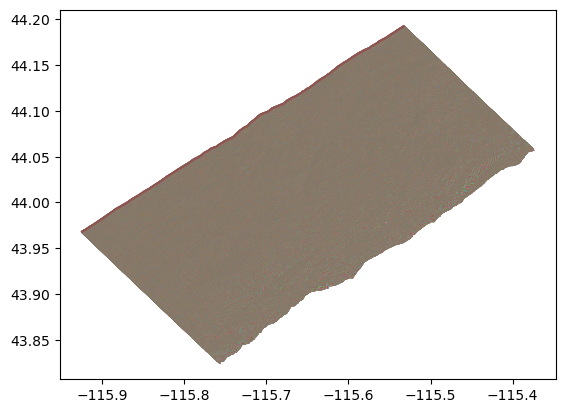

In [25]:
lats = np.fromfile(llh_05208, 'f4')[0::3].reshape(8333, 4896)
longs =  np.fromfile(llh_05208, 'f4')[1::3].reshape(8333, 4896)
heights = np.fromfile(llh_05208, 'f4')[2::3].reshape(8333, 4896)

print(f"Latitude max: {np.max(lats)}, min {np.min(lats)}")
print(f"Longitude max: {np.max(longs)}, min {np.min(longs)}")

import matplotlib.pyplot as plt

plot = plt.plot(longs, lats)


In [1]:
img_list = ['/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/geog6655_coherence/data/data/snowex_lowman/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif',
 '/Users/julo9057/Library/CloudStorage/OneDrive-UCB-O365/Documents/geog6655_coherence/data/data/snowex_lowman/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.imag.tif']

Here are loops to run the geocoding script for each slc. It ran for about 35 minutes for all 23 SLCs

In [ ]:
# for slc, ann in zip(slcs_23205, anns_23205):
#     geolocate_uavsar(str(slc), str(ann), data_dir, llh_23205)

# for slc, ann in zip(slcs_05208, anns_05208):
#     geolocate_uavsar(str(slc), str(ann), data_dir, llh_05208)

/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/geog6

In [ ]:
def real_imag_to_slc(real_path, imag_path, output_path):
    # import rioxarray as rxa
    # import numpy as np

    real = rxa.open_rasterio(real_path, parse_coordinates=True)
    imag = rxa.open_rasterio(imag_path, parse_coordinates=True)
    # create a complex dataarray with imag and real values
    slc = real.copy(data=np.empty(real.shape, dtype=np.complex64))
    slc.values = real.values + 1j * imag.values
    slc.rio.to_raster(output_path)
    return slc

in_dir = Path("../data/snowex_lowman/slcs_geocoded/")
imaginaries = sorted(list(in_dir.glob('*imag*')))
reals = sorted(list(in_dir.glob('*real*')))

print(imaginaries[0])
print(reals[0])

slc = real_imag_to_slc(reals[0], imaginaries[0], str(in_dir) + "/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.tif")

../data/snowex_lowman/slcs_geocoded/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.imag.tif
../data/snowex_lowman/slcs_geocoded/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif


In [37]:
for real, imag in zip(reals, imaginaries):
    out_dir = "../data/snowex_lowman/slcs_geocoded/"
    output_path = real.name.replace('.real.', '.')
    print(f"Creating SLC {output_path}")
    slc = real_imag_to_slc(real, imag, out_dir + output_path)

Creating SLC lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_20011_002_200221_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_20016_003_200311_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21009_005_210203_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21012_004_210210_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21015_009_210303_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21017_019_210310_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21019_019_210316_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_05208_21021_007_210322_L090VV_01_BU_s2_2x8.slc.tif
Creating SLC lowman_23205_20002_007_200131_L090VV_01_BC_s2_2x8.slc.tif
Creating SLC lowman_23205_20007_003_200213_L090VV_01_BC_s2_2x8.slc.tif
Creating SLC lowman_23205_20011_003_200221_L090VV_01_BC_s2_2x8.slc.tif
Creating SLC lowman_23205_20016_004_200311_L090VV_01_BC_s2_2x8.slc.tif
Creati

### Plot the geolocated files



In [30]:
import rioxarray as rxa
import xarray as xr
import matplotlib.pyplot as plt

data_dir = "../data/snowex_lowman/slcs_geocoded/"

-9999.0
14.992923736572266
(-115.78172422468924, 43.96779286703164, -115.51764754468925, 44.04996610703165)


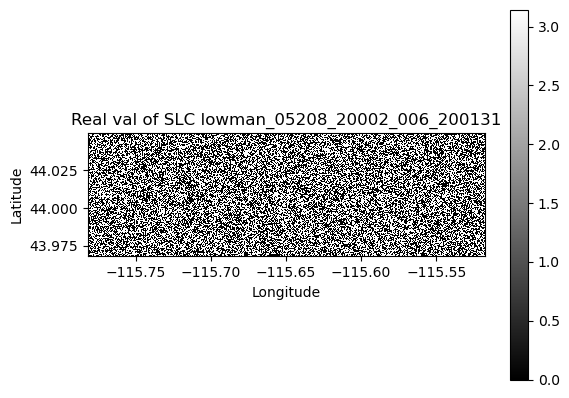

In [32]:
data_array = rxa.open_rasterio(data_dir + "lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif", parse_coordinates=True)
# data_array.rio.write_nodata(-9999.0, inplace=True)
print(data_array.min().values)
print(data_array.max().values)

print(data_array.rio.bounds())

# get phase of slc 
phase = data_array.copy(data=np.empty(data_array.shape, dtype=xr.DataArray))
# print(type(phase))
# print(phase.rio.crs)
phase.values = xr.DataArray(np.angle(data_array))

ax = phase.real.plot(cmap='gray')
ax.axes.set_aspect('equal')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Real val of SLC lowman_05208_20002_006_200131")

plt.show()

In [114]:
from scipy.signal import convolve2d
def calc_coherence_unweighted1(img1, img2, window=13) :

    # create window over which to do the magnitude calculation 
    kernel = np.ones((window, window), dtype=np.float32)
    kernel /= kernel.sum()

    if (type(img1) == xr.DataArray) or (type(img2) == xr.DataArray) :
        img1_arr = img1.values[0,:,:]
        img2_arr = img2.values[0,:,:]
        out_arr = img1.copy(data=np.empty(img1.shape, dtype=np.complex64))
    else :
        img1_arr = img1
        img2_arr = img2

    # Numerator: E[u1 * conj(u2)] a.k.a. the cross product of the two complex numbers
    cross_prod = img1_arr * np.conj(img2_arr)

    print(type(cross_prod))
    print((cross_prod.real.shape))

    # convolve2d does the leg work of moving the window over all pixels. 
    # the 'symm' boundary creates a mirror reflection to fill in areas for pixels at the edges
    num_real = convolve2d(cross_prod.real, kernel, mode='same', boundary='symm')
    num_imag = convolve2d(cross_prod.imag, kernel, mode='same', boundary='symm')
    # put the separate components back together 
    numerator = num_real + 1j * num_imag

    # Denominator: sqrt(E[|u1|^2] * E[|u2|^2])
    power1 = convolve2d(np.abs(img1_arr)**2, kernel, mode='same', boundary='symm')
    power2 = convolve2d(np.abs(img2_arr)**2, kernel, mode='same', boundary='symm')
    denom = np.sqrt(power1 * power2)
    denom[denom == 0] = 1e-12  # Prevent divide by zero

    # Coherence magnitude
    coherence = np.abs(numerator / denom)

    if (type(img1) == xr.DataArray) or (type(img2) == xr.DataArray) :
        out_arr.values = coherence.reshape(img1.shape)
    else :
        out_arr = coherence
    return out_arr

In [115]:
print(phase.rio.bounds())
real = rxa.open_rasterio("../data/snowex_lowman/slcs_geocoded/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.real.tif", parse_coordinates=True)
print(real.rio.bounds())

slc1 = rxa.open_rasterio(data_dir + "lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc.tif", parse_coordinates=True)
slc2 = rxa.open_rasterio(data_dir + "lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc.tif", parse_coordinates=True)

print(type(slc1))

coh12 = calc_coherence_unweighted1(slc1, slc2)


(-115.78172422468924, 43.96779286703164, -115.51764754468925, 44.04996610703165)
(-115.78172422468924, 43.96779286703164, -115.51764754468925, 44.04996610703165)
<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>
(1479, 4753)


<class 'xarray.core.dataarray.DataArray'>


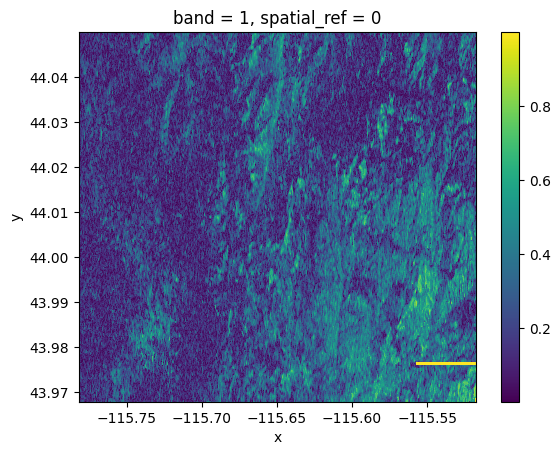

In [117]:
print(type(coh12))
coh12.plot()
# coh.rio.to_raster(data_dir + "coherence_lowman_52.tif")

/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


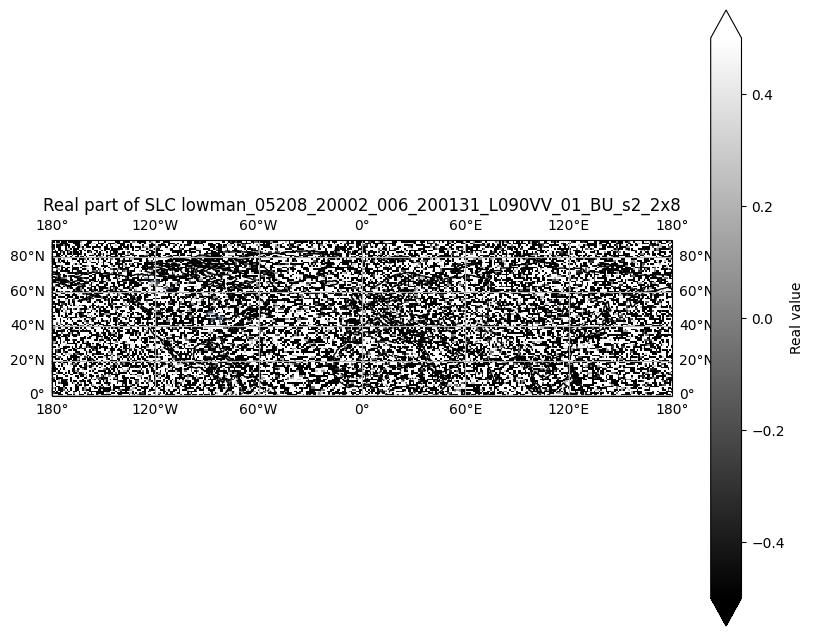

In [ ]:
# Plotting with basemap 

import cartopy as ccrs

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.crs.PlateCarree()) # Or other suitable projection
phase.plot(ax=ax, transform=ccrs.crs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap='gray', cbar_kwargs={'label': 'Real value'})
ax.coastlines()
ax.add_feature(ccrs.feature.BORDERS, linestyle=':')
ax.add_feature(ccrs.feature.LAKES, alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('Phase of SLC lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8')
plt.show()